In [499]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vol import robust_vol_cal

In [500]:
import yfinance as yf

In [524]:
sp500 = yf.download('VET-USD', start = "2005-05-01", interval= '1d')
price = sp500['Adj Close']
ret = price.pct_change().fillna(0)

np.random.seed(100)
#daily_returns = pd.Series(np.random.normal(0, 0.025, 3000), index=pd.date_range(start='2015-01-01', periods=3000))
#price = (1 + daily_returns).cumprod()

# calculate weighted variations
pairs = [[10, 40], [20, 80], [40, 160], [60, 240]]


forecast_mat = np.zeros((len(price), len(pairs)))

vol = robust_vol_cal(price.pct_change())
vol_f = robust_vol_cal(price.diff(), days=125)
fast = 24
slow = fast * 4
fast_ma = price.rolling(fast, min_periods=10).mean()
slow_ma = price.rolling(slow, min_periods=10).mean()
raw_ma = fast_ma - slow_ma
forecast = (raw_ma/vol_f).clip(lower = 0, upper = 20)


inital_cash = 20000
pct_annual_volatility_target = 0.3

cash_annual_vol_targ = inital_cash * pct_annual_volatility_target
cash_daily_vol_targ = cash_annual_vol_targ / np.sqrt(252)

block_vol = price * vol

# calculate the share needed for each day
share_needed = cash_daily_vol_targ / block_vol
share_needed_afterforecast = share_needed*forecast/10
cash_needed = share_needed_afterforecast * price
share_needed_afterforecast

[*********************100%%**********************]  1 of 1 completed
/Users/tonghuang/Desktop/Trading/Backtester/vol.py:85: FutureWarning: the 'quantile' keyword is deprecated, use 'q' instead.
  vol_min = vol.rolling(min_periods=floor_min_periods, window=floor_days).quantile(


Date
2018-08-03             NaN
2018-08-04             NaN
2018-08-05             NaN
2018-08-06             NaN
2018-08-07             NaN
                  ...     
2024-02-22    39336.758622
2024-02-23    44652.817605
2024-02-24    49394.547217
2024-02-25    54673.532312
2024-02-26    46961.045044
Name: Adj Close, Length: 2034, dtype: float64

In [525]:
cash_needed

Date
2018-08-03            NaN
2018-08-04            NaN
2018-08-05            NaN
2018-08-06            NaN
2018-08-07            NaN
                 ...     
2024-02-22    1766.181193
2024-02-23    1946.327071
2024-02-24    2196.526066
2024-02-25    2458.778028
2024-02-26    2364.856313
Name: Adj Close, Length: 2034, dtype: float64

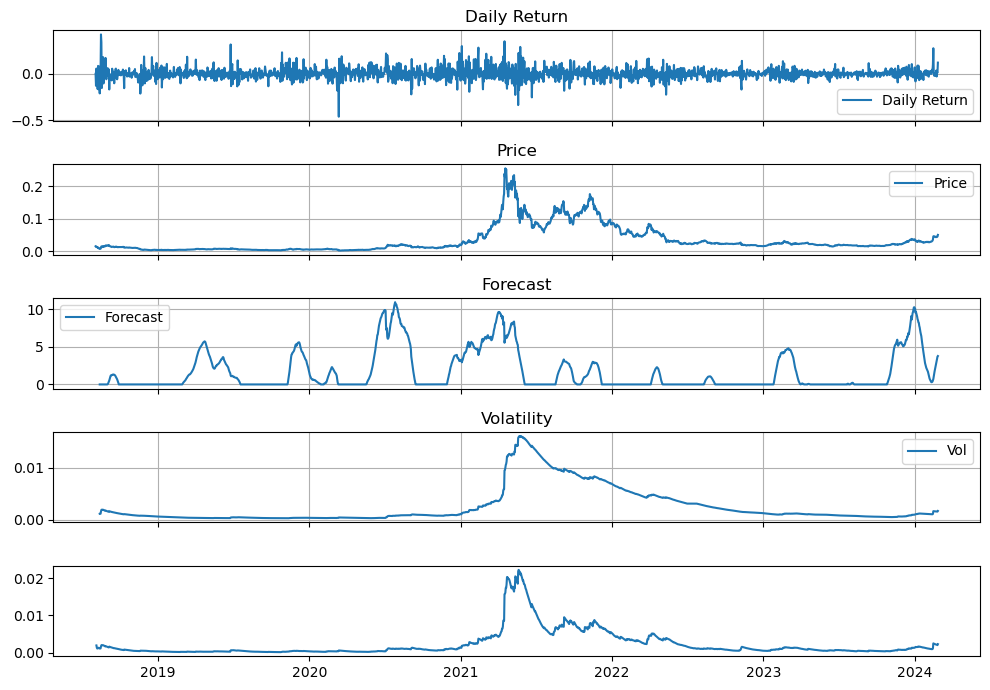

Date
2024-01-08    8.660836
2024-01-09    8.519946
2024-01-10    8.241659
2024-01-11    8.196679
2024-01-12    7.791390
2024-01-13    7.590039
2024-01-14    7.215334
2024-01-15    6.914866
2024-01-16    6.659894
2024-01-17    6.416800
2024-01-18    5.906578
2024-01-19    5.525943
2024-01-20    5.153426
2024-01-21    4.801833
2024-01-22    4.320936
2024-01-23    3.923851
2024-01-24    3.591124
2024-01-25    3.177183
2024-01-26    2.831809
2024-01-27    2.620468
2024-01-28    2.370526
2024-01-29    2.203845
2024-01-30    2.081459
2024-01-31    1.986678
2024-02-01    1.805945
2024-02-02    1.686831
2024-02-03    1.444026
2024-02-04    1.151849
2024-02-05    0.961168
2024-02-06    0.764141
2024-02-07    0.648720
2024-02-08    0.514997
2024-02-09    0.396317
2024-02-10    0.305219
2024-02-11    0.291915
2024-02-12    0.323893
2024-02-13    0.385146
2024-02-14    0.539358
2024-02-15    0.714680
2024-02-16    1.075346
2024-02-17    1.393788
2024-02-18    1.724977
2024-02-19    2.021233
2024-0

In [526]:
fig, axs = plt.subplots(5, 1, figsize=(10, 7), sharex=True)  # Enable sharing x-axis

# Plot daily return
axs[0].plot(ret, label='Daily Return')
axs[0].set_title('Daily Return')
axs[0].legend(loc='best')
axs[0].grid()
# Plot price
axs[1].plot(price, label='Price')
axs[1].set_title('Price')
axs[1].legend(loc='best')
axs[1].grid()
# Plot forecast
axs[2].plot(forecast, label='Forecast')
axs[2].set_title('Forecast')
axs[2].legend(loc='best')
axs[2].grid()
# Improve layout and display the figure
axs[3].plot(vol_f, label = 'Vol')
axs[3].set_title('Volatility')
axs[3].legend(loc='best')
axs[3].grid()

axs[4].plot(price.diff().ewm(adjust = True, span=35).std())

plt.tight_layout()
plt.show()

print(forecast.tail(50))

Date
2018-08-03    0.015307
2018-08-04    0.013333
2018-08-05    0.014081
2018-08-06    0.013424
2018-08-07    0.012899
                ...   
2024-02-22    0.044899
2024-02-23    0.043588
2024-02-24    0.044469
2024-02-25    0.044972
2024-02-26    0.050573
Name: Adj Close, Length: 2034, dtype: float64


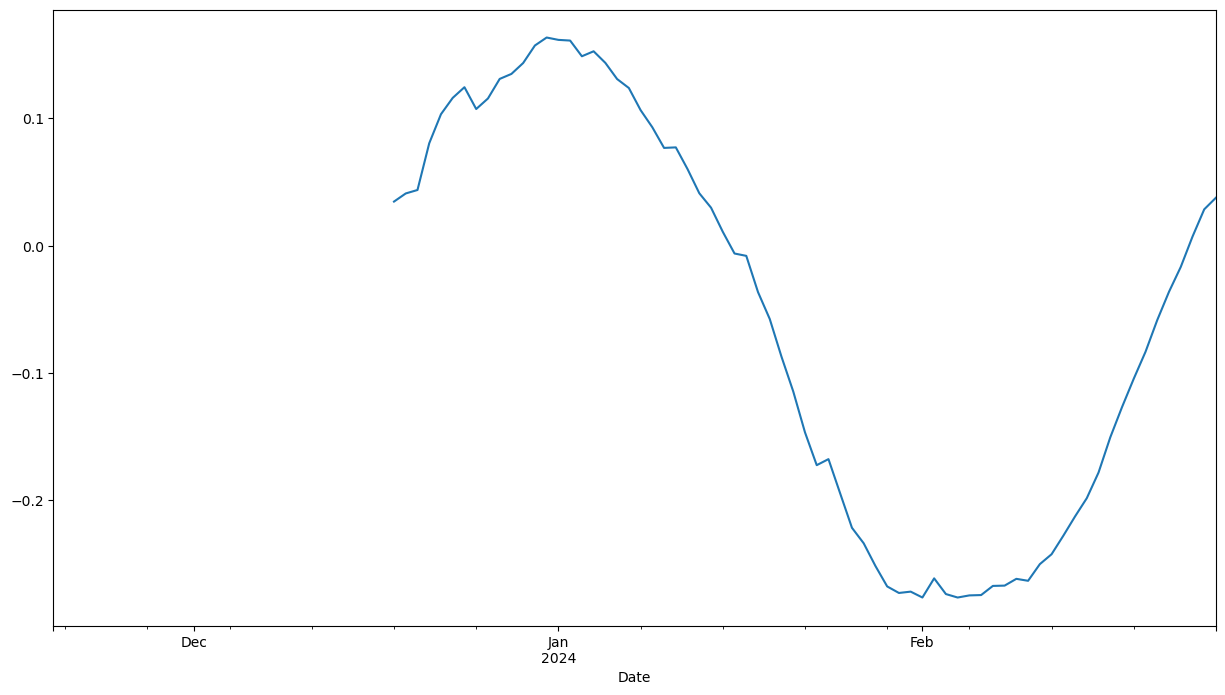

In [505]:
forecast.diff().tail(100).rolling(window = 30).mean().plot(figsize = (15,8))

print(price)

In [458]:
share_needed = share_needed.fillna(0)
cash_needed = cash_needed.fillna(0)
cash_position = [20000]
asset_position = [0]
#share_needed = share_needed.shift()
#cash_needed = cash_needed.shift()
forecast = forecast.shift(1).fillna(0)  # Ensure forecast is shifted appropriately
i = 1
while i < len(price):
    # Assume decisions are based on forecast information up to day i-1
    adjustment_factor = forecast.iloc[i-1] 
    share_change = share_needed.iloc[i] - share_needed.iloc[i-1]
    asset_adjustment = cash_needed.iloc[i-1]  * adjustment_factor# Use cash_needed from previous day
    cost = abs(share_change) * 0.025 * price[i]
    
    if asset_adjustment > cash_position[i-1]:
        port = cash_position[i-1] * (1 + ret.iloc[i-1])
        port -= cost
        cash_position.append(port)
    else:
        cash = cash_position[i-1] - asset_adjustment
        # Asset's value adjustment based on yesterday's return, realized today
        asset_value_today = asset_adjustment * (1 + ret.iloc[i-1])
        cash += asset_value_today  # Update cash with realized asset value
        cash -= cost
        cash_position.append(cash)
    i += 1

    

/var/folders/qn/03t76jqd1t31l24v1ryyyxkr0000gn/T/ipykernel_40210/3057294278.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cost = abs(share_change) * 0.025 * price[i]


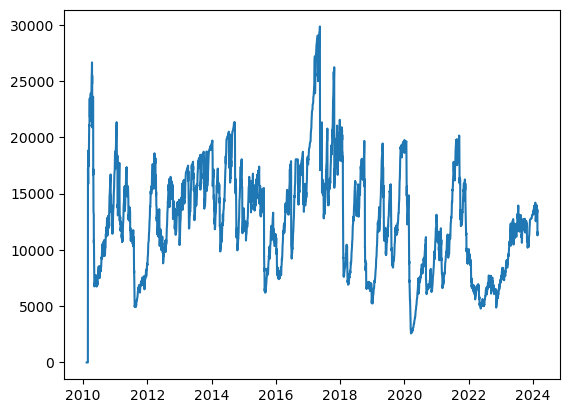

In [459]:
plt.plot(cash_needed)

In [460]:
# generate buy and hold

buy_and_hold = (20000 * (1 + ret).cumprod())

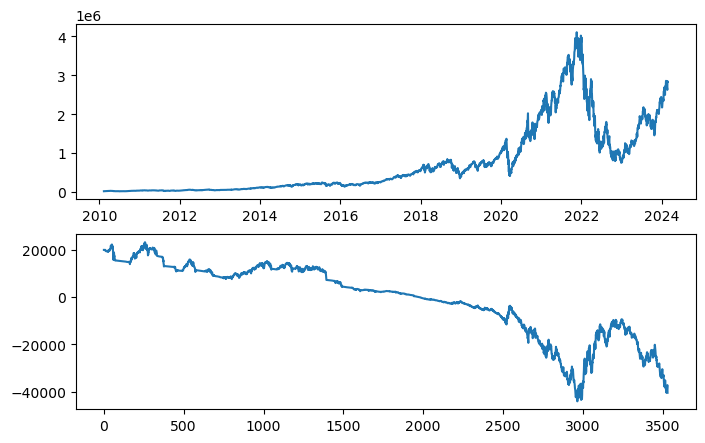

In [461]:
fig, axs = plt.subplots(2, 1, figsize = (8, 5))


axs[0].plot(buy_and_hold)
axs[1].plot(cash_position)

In [462]:
s = pd.Series(cash_position)

# Calculate daily returns and filter out days with no change
s_ret = s.pct_change().fillna(0)
non_zero_returns = s_ret[s_ret != 0]

# Calculate and print the skewness of non-zero returns
skewness = non_zero_returns.skew()
print(f"Skewness of non-zero returns: {skewness}")

Skewness of non-zero returns: 54.41698558124229


In [361]:
buy_and_hold.pct_change().fillna(0).skew()

0.18876584690033058

In [362]:
# BUY AND HOLD SHARPE
daily_returns = buy_and_hold.pct_change().fillna(0)

# Calculate cumulative return
cumulative_return = (1 + daily_returns).cumprod().iloc[-1] - 1

# Calculate the number of years the investment was held
n_years = (buy_and_hold.index[-1] - buy_and_hold.index[0]).days / 252

# Calculate annualized return
annualized_return = (1 + cumulative_return) ** (1 / n_years) - 1

std_dev_daily = daily_returns.std()

# Annualize the volatility
annualized_volatility = std_dev_daily * np.sqrt(252)

sharpe_buy_and_hold = annualized_return/annualized_volatility
sharpe_buy_and_hold

0.5202457698646582

In [363]:
daily_returns = s.pct_change().fillna(0)

# Calculate cumulative return
cumulative_return = (1 + daily_returns).cumprod().iloc[-1] - 1

# Calculate the number of years the investment was held
n_years = (s.index[-1] - s.index[0]) / 252

# Calculate annualized return
annualized_return = (1 + cumulative_return) ** (1 / n_years) - 1

std_dev_daily = daily_returns.std()

# Annualize the volatility
annualized_volatility = std_dev_daily * np.sqrt(252)

sharpe_s = annualized_return/annualized_volatility
sharpe_s

0.8236572347402433

In [85]:
sol = yf.download('SOL-USD', start = '2020-01-01', interval = '1d')
btc = yf.download('BTC-USD', start = '2020-01-01', interval = '1d')
sol = sol['Adj Close']
btc = btc['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [87]:
sol.corr(btc)

0.7025159776406833

# Trading variations correlation calculation

In [143]:

pairs = [[10, 40], [20, 80], [40, 160], [60, 240]]


forecast_mat = np.zeros((len(price), len(pairs)))

for i, (fast, slow) in enumerate(pairs):
    fast_ma = price.rolling(fast, min_periods=10).mean()
    slow_ma = price.rolling(slow, min_periods=10).mean()
    raw_ma = fast_ma - slow_ma
    forecast = (raw_ma/vol_f).clip(lower = -20, upper = 20)
    forecast_mat[:, i] = forecast

In [144]:
name = [str(pair) for pair in pairs]
forecast_df = pd.DataFrame(forecast_mat, columns=name)
forecast_df.corr()

,"[10, 40]","[20, 80]","[40, 160]","[60, 240]"
"[10, 40]",1.000000,0.806647,0.435907,0.313916
"[20, 80]",0.806647,1.000000,0.757811,0.538585
"[40, 160]",0.435907,0.757811,1.000000,0.888766
"[60, 240]",0.313916,0.538585,0.888766,1.000000


In [145]:
inverse_variance_weights = 1 / np.diag(forecast_df.corr())
inverse_variance_weights
normalized_weights = inverse_variance_weights / np.sum(inverse_variance_weights)

In [148]:
normalized_weights.shape

(4,)

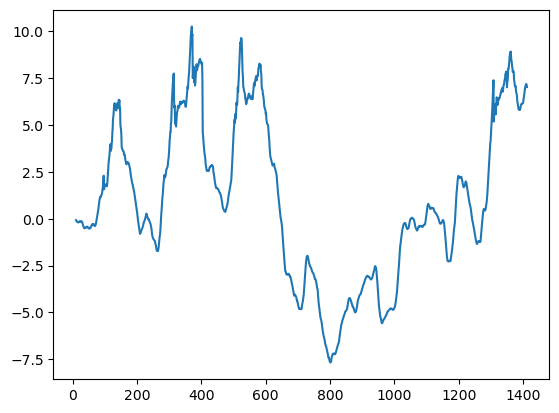

In [154]:
plt.plot(forecast_mat @ normalized_weights)

In [251]:
3/51

0.058823529411764705

In [252]:
1/13

0.07692307692307693